# dataset: https://universe.roboflow.com/new-workspace-mujgg/yoga-pose

In [1]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.0 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of opencv-contrib-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 69.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 126.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 113.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 11.4 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled

In [10]:
import os
import shutil

!mkdir -p /content/dataset/train
# !mkdir -p /content/dataset/test
# !mkdir -p /content/dataset/valid

!unzip -q /content/train.zip -d /content/dataset/train
# !unzip -q /content/test.zip -d /content/dataset/test
# !unzip -q /content/valid.zip -d /content/dataset/valid

!find /content/dataset -type d -name "__MACOSX" -exec rm -rf {} +

def auto_flatten(folder):
    items = os.listdir(folder)
    if len(items) == 1:
        inner = os.path.join(folder, items[0])
        if os.path.isdir(inner):
            for cls in os.listdir(inner):
                shutil.move(os.path.join(inner, cls), folder)
            shutil.rmtree(inner)

auto_flatten("/content/dataset/train")
# auto_flatten("/content/dataset/test")
# auto_flatten("/content/dataset/valid")

print(os.listdir("/content/dataset/train"))
# print(os.listdir("/content/dataset/test"))
# print(os.listdir("/content/dataset/valid"))


['.DS_Store', 'tadasana', 'anjaneyasana', 'paschimottanasana', 'salamba sarvangasana', 'bhujangasana', 'natarajasana', 'virabhadrasana ii', 'uttanasana', 'phalakasana', 'padmasana', 'adho mukha svanasana', 'vriksasana', 'dhanurasana', 'setu bandha sarvangasana', 'utthita trikonasana']


# Dataset: https://universe.roboflow.com/new-workspace-mujgg/yoga-pose 

# Preprocessing

![Screenshot 2025-11-27 at 4.24.31 PM.png](<attachment:Screenshot 2025-11-27 at 4.24.31 PM.png>)
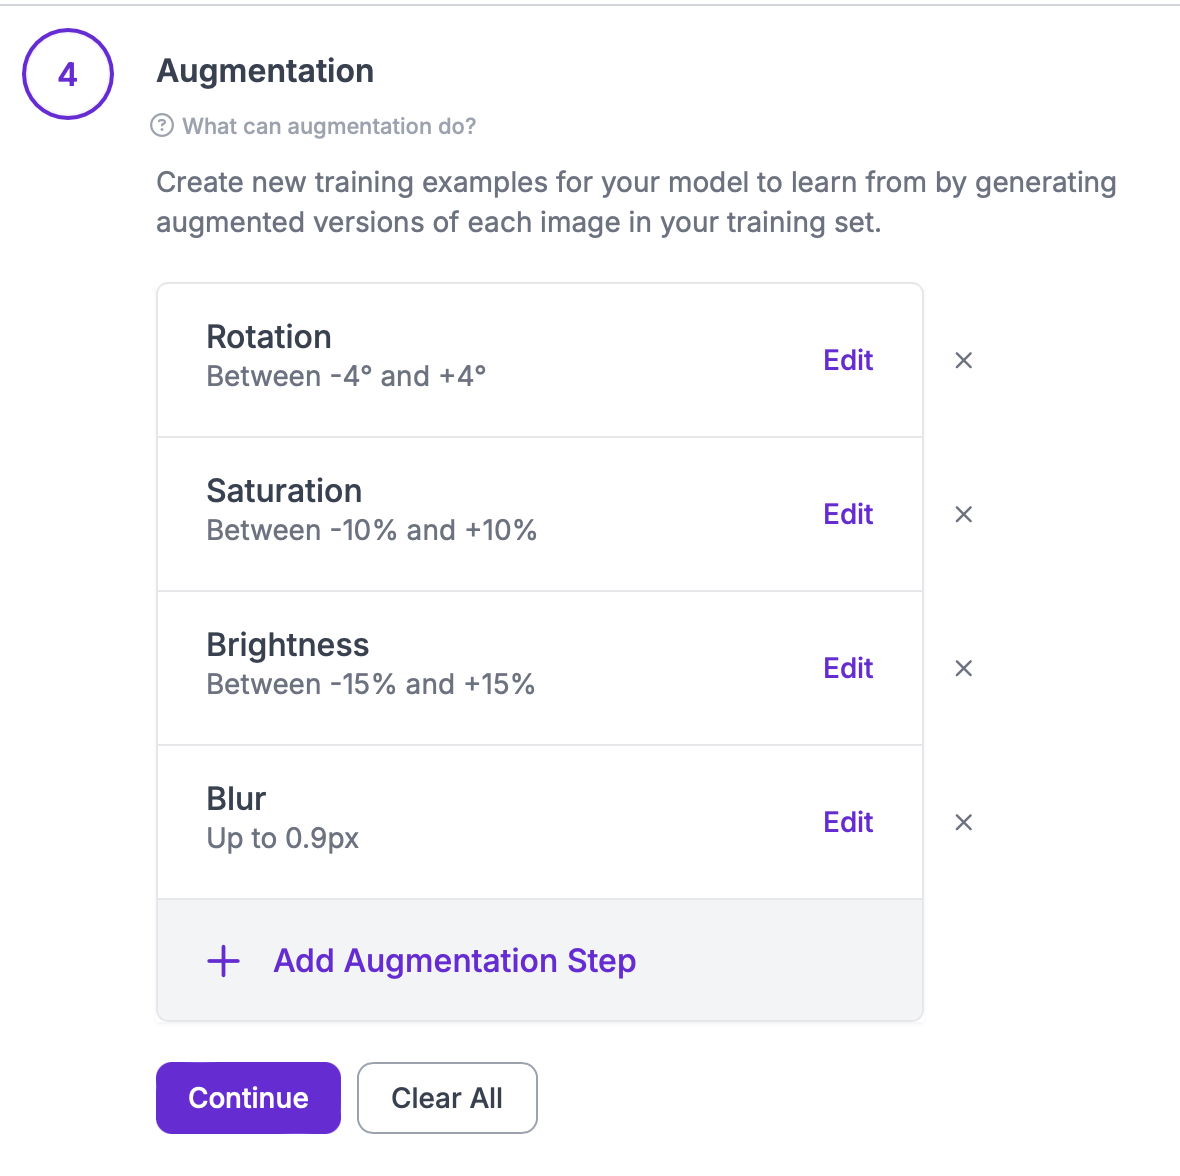

# Feature Extraction
1. Keypoint Extraction:
Use MediaPipe to detect 33 body landmarks (keypoints) from input images.

2. Feature Extraction:
Calculate geometric features from keypoints:
    - Joint angles (e.g., elbows, knees, shoulders)
    - Distances between important points (e.g., hands, feet)
    - Normalized body ratios (e.g., arm length to body height)
    - Symmetry differences between left and right body parts

In [1]:
import os
import cv2
import matplotlib.pyplot as plt

train_dir = "/content/dataset/train"
classes = sorted(os.listdir(train_dir))

classes = [c for c in classes if os.path.isdir(os.path.join(train_dir, c))]

n = len(classes)
cols = 5
rows = (n // cols) + 1

plt.figure(figsize=(20, 12))

for i, cls in enumerate(classes):
    class_path = os.path.join(train_dir, cls)
    imgs = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg','.jpeg','.png'))]

    if len(imgs) == 0:
        continue

    img_name = imgs[0]
    img_path = os.path.join(class_path, img_name)

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.title(f"{cls}\n{img_name}", fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.show()


<Figure size 2000x1200 with 0 Axes>

In [2]:
import cv2
import numpy as np
import mediapipe as mp
import pickle
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd
from google.colab import files
import matplotlib.pyplot as plt

/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.2 is installed, but it is not compatible with the installed jaxlib version 0.7.1, so it will not be used.
  warnings.warn(


In [3]:
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

pose = mp_pose.Pose(
    static_image_mode=True,
    model_complexity=2,
    enable_segmentation=False,
    min_detection_confidence=0.5
)

In [4]:
def calculate_angle(p1, p2, p3):
    """
    Calculate angle between three points (p1-p2-p3)
    p2 is the vertex (middle point)

    Args:
        p1, p2, p3: landmarks with .x, .y attributes

    Returns:
        angle in degrees
    """
    # Convert to numpy arrays
    a = np.array([p1.x, p1.y])
    b = np.array([p2.x, p2.y])
    c = np.array([p3.x, p3.y])

    # Calculate vectors
    ba = a - b
    bc = c - b

    # Calculate angle using dot product
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc) + 1e-6)
    angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))

    return np.degrees(angle)

In [5]:
def calculate_distance(p1, p2):
    """Calculate Euclidean distance between two points"""
    return np.sqrt((p1.x - p2.x)**2 + (p1.y - p2.y)**2)

In [6]:
def extract_pose_features(landmarks):
    """
    Extract comprehensive features from pose landmarks

    Returns:
        numpy array of ~50 features
    """
    features = []

    # Get landmark shortcuts
    lm = landmarks.landmark

    # ==================== ANGLE FEATURES ====================

    # Left arm angles
    left_shoulder_angle = calculate_angle(
        lm[mp_pose.PoseLandmark.LEFT_ELBOW],
        lm[mp_pose.PoseLandmark.LEFT_SHOULDER],
        lm[mp_pose.PoseLandmark.LEFT_HIP]
    )
    features.append(left_shoulder_angle)

    left_elbow_angle = calculate_angle(
        lm[mp_pose.PoseLandmark.LEFT_SHOULDER],
        lm[mp_pose.PoseLandmark.LEFT_ELBOW],
        lm[mp_pose.PoseLandmark.LEFT_WRIST]
    )
    features.append(left_elbow_angle)

    # Right arm angles
    right_shoulder_angle = calculate_angle(
        lm[mp_pose.PoseLandmark.RIGHT_ELBOW],
        lm[mp_pose.PoseLandmark.RIGHT_SHOULDER],
        lm[mp_pose.PoseLandmark.RIGHT_HIP]
    )
    features.append(right_shoulder_angle)

    right_elbow_angle = calculate_angle(
        lm[mp_pose.PoseLandmark.RIGHT_SHOULDER],
        lm[mp_pose.PoseLandmark.RIGHT_ELBOW],
        lm[mp_pose.PoseLandmark.RIGHT_WRIST]
    )
    features.append(right_elbow_angle)

    # Left leg angles
    left_hip_angle = calculate_angle(
        lm[mp_pose.PoseLandmark.LEFT_SHOULDER],
        lm[mp_pose.PoseLandmark.LEFT_HIP],
        lm[mp_pose.PoseLandmark.LEFT_KNEE]
    )
    features.append(left_hip_angle)

    left_knee_angle = calculate_angle(
        lm[mp_pose.PoseLandmark.LEFT_HIP],
        lm[mp_pose.PoseLandmark.LEFT_KNEE],
        lm[mp_pose.PoseLandmark.LEFT_ANKLE]
    )
    features.append(left_knee_angle)

    # Right leg angles
    right_hip_angle = calculate_angle(
        lm[mp_pose.PoseLandmark.RIGHT_SHOULDER],
        lm[mp_pose.PoseLandmark.RIGHT_HIP],
        lm[mp_pose.PoseLandmark.RIGHT_KNEE]
    )
    features.append(right_hip_angle)

    right_knee_angle = calculate_angle(
        lm[mp_pose.PoseLandmark.RIGHT_HIP],
        lm[mp_pose.PoseLandmark.RIGHT_KNEE],
        lm[mp_pose.PoseLandmark.RIGHT_ANKLE]
    )
    features.append(right_knee_angle)

    # Spine/torso angles
    spine_angle = calculate_angle(
        lm[mp_pose.PoseLandmark.LEFT_SHOULDER],
        lm[mp_pose.PoseLandmark.LEFT_HIP],
        lm[mp_pose.PoseLandmark.LEFT_KNEE]
    )
    features.append(spine_angle)

    # Neck angle
    neck_angle = calculate_angle(
        lm[mp_pose.PoseLandmark.LEFT_SHOULDER],
        lm[mp_pose.PoseLandmark.NOSE],
        lm[mp_pose.PoseLandmark.LEFT_EAR]
    )
    features.append(neck_angle)

    # ==================== DISTANCE FEATURES ====================

    # Hand distance (for poses with hands together)
    hand_distance = calculate_distance(
        lm[mp_pose.PoseLandmark.LEFT_WRIST],
        lm[mp_pose.PoseLandmark.RIGHT_WRIST]
    )
    features.append(hand_distance)

    # Foot distance (for poses with wide stance)
    foot_distance = calculate_distance(
        lm[mp_pose.PoseLandmark.LEFT_ANKLE],
        lm[mp_pose.PoseLandmark.RIGHT_ANKLE]
    )
    features.append(foot_distance)

    # ==================== RATIO FEATURES (body size normalized) ====================

    # Calculate body height (shoulder to ankle)
    body_height = calculate_distance(
        lm[mp_pose.PoseLandmark.LEFT_SHOULDER],
        lm[mp_pose.PoseLandmark.LEFT_ANKLE]
    )

    # Arm length ratios
    left_arm_length = calculate_distance(
        lm[mp_pose.PoseLandmark.LEFT_SHOULDER],
        lm[mp_pose.PoseLandmark.LEFT_WRIST]
    )
    features.append(left_arm_length / (body_height + 1e-6))

    right_arm_length = calculate_distance(
        lm[mp_pose.PoseLandmark.RIGHT_SHOULDER],
        lm[mp_pose.PoseLandmark.RIGHT_WRIST]
    )
    features.append(right_arm_length / (body_height + 1e-6))

    # ==================== POSITION FEATURES ====================

    # Y-coordinates (height) of key points (normalized)
    features.append(lm[mp_pose.PoseLandmark.LEFT_WRIST].y)
    features.append(lm[mp_pose.PoseLandmark.RIGHT_WRIST].y)
    features.append(lm[mp_pose.PoseLandmark.LEFT_ANKLE].y)
    features.append(lm[mp_pose.PoseLandmark.RIGHT_ANKLE].y)
    features.append(lm[mp_pose.PoseLandmark.NOSE].y)

    # X-coordinates (width) - for left/right alignment
    features.append(lm[mp_pose.PoseLandmark.LEFT_SHOULDER].x)
    features.append(lm[mp_pose.PoseLandmark.RIGHT_SHOULDER].x)

    # ==================== SYMMETRY FEATURES ====================

    # Arm symmetry (difference between left and right)
    arm_symmetry = abs(left_elbow_angle - right_elbow_angle)
    features.append(arm_symmetry)

    # Leg symmetry
    leg_symmetry = abs(left_knee_angle - right_knee_angle)
    features.append(leg_symmetry)

    # Shoulder level difference
    shoulder_level = abs(lm[mp_pose.PoseLandmark.LEFT_SHOULDER].y -
                         lm[mp_pose.PoseLandmark.RIGHT_SHOULDER].y)
    features.append(shoulder_level)

    # Hip level difference
    hip_level = abs(lm[mp_pose.PoseLandmark.LEFT_HIP].y -
                    lm[mp_pose.PoseLandmark.RIGHT_HIP].y)
    features.append(hip_level)

    return np.array(features)

In [21]:
def process_image(image_path):
    """
    Process a single image and extract pose features.
    Returns:
        features (numpy array) or None if pose not detected
    """
    image = cv2.imread(image_path)
    if image is None:
        return None

    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Run MediaPipe
    results = pose.process(img_rgb)

    # If no pose → skip image
    if not results.pose_landmarks:
        return None

    # Extract features from landmarks
    features = extract_pose_features(results.pose_landmarks)

    return features


In [8]:
def load_dataset(dataset_path):
    X = []
    y = []
    pose_names = []

    # Get all pose folders
    pose_folders = sorted([f for f in os.listdir(dataset_path)
                          if os.path.isdir(os.path.join(dataset_path, f))])

    print(f"\nFound {len(pose_folders)} pose classes:")
    for i, pose in enumerate(pose_folders):
        print(f"   {i}: {pose}")

    # Process each pose class
    for pose_idx, pose_name in enumerate(pose_folders):
        pose_path = os.path.join(dataset_path, pose_name)
        image_files = [f for f in os.listdir(pose_path)
                      if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        print(f"\nProcessing {pose_name}: {len(image_files)} images...")

        success_count = 0
        for img_file in image_files:
            img_path = os.path.join(pose_path, img_file)
            features = process_image(img_path)

            if features is not None:
                X.append(features)
                y.append(pose_idx)
                success_count += 1

        print(f"Successfully processed: {success_count}/{len(image_files)} images")
        pose_names.append(pose_name)

    X = np.array(X)
    y = np.array(y)

    print(f"\nDataset loaded: {X.shape[0]} samples, {X.shape[1]} features")

    return X, y, pose_names

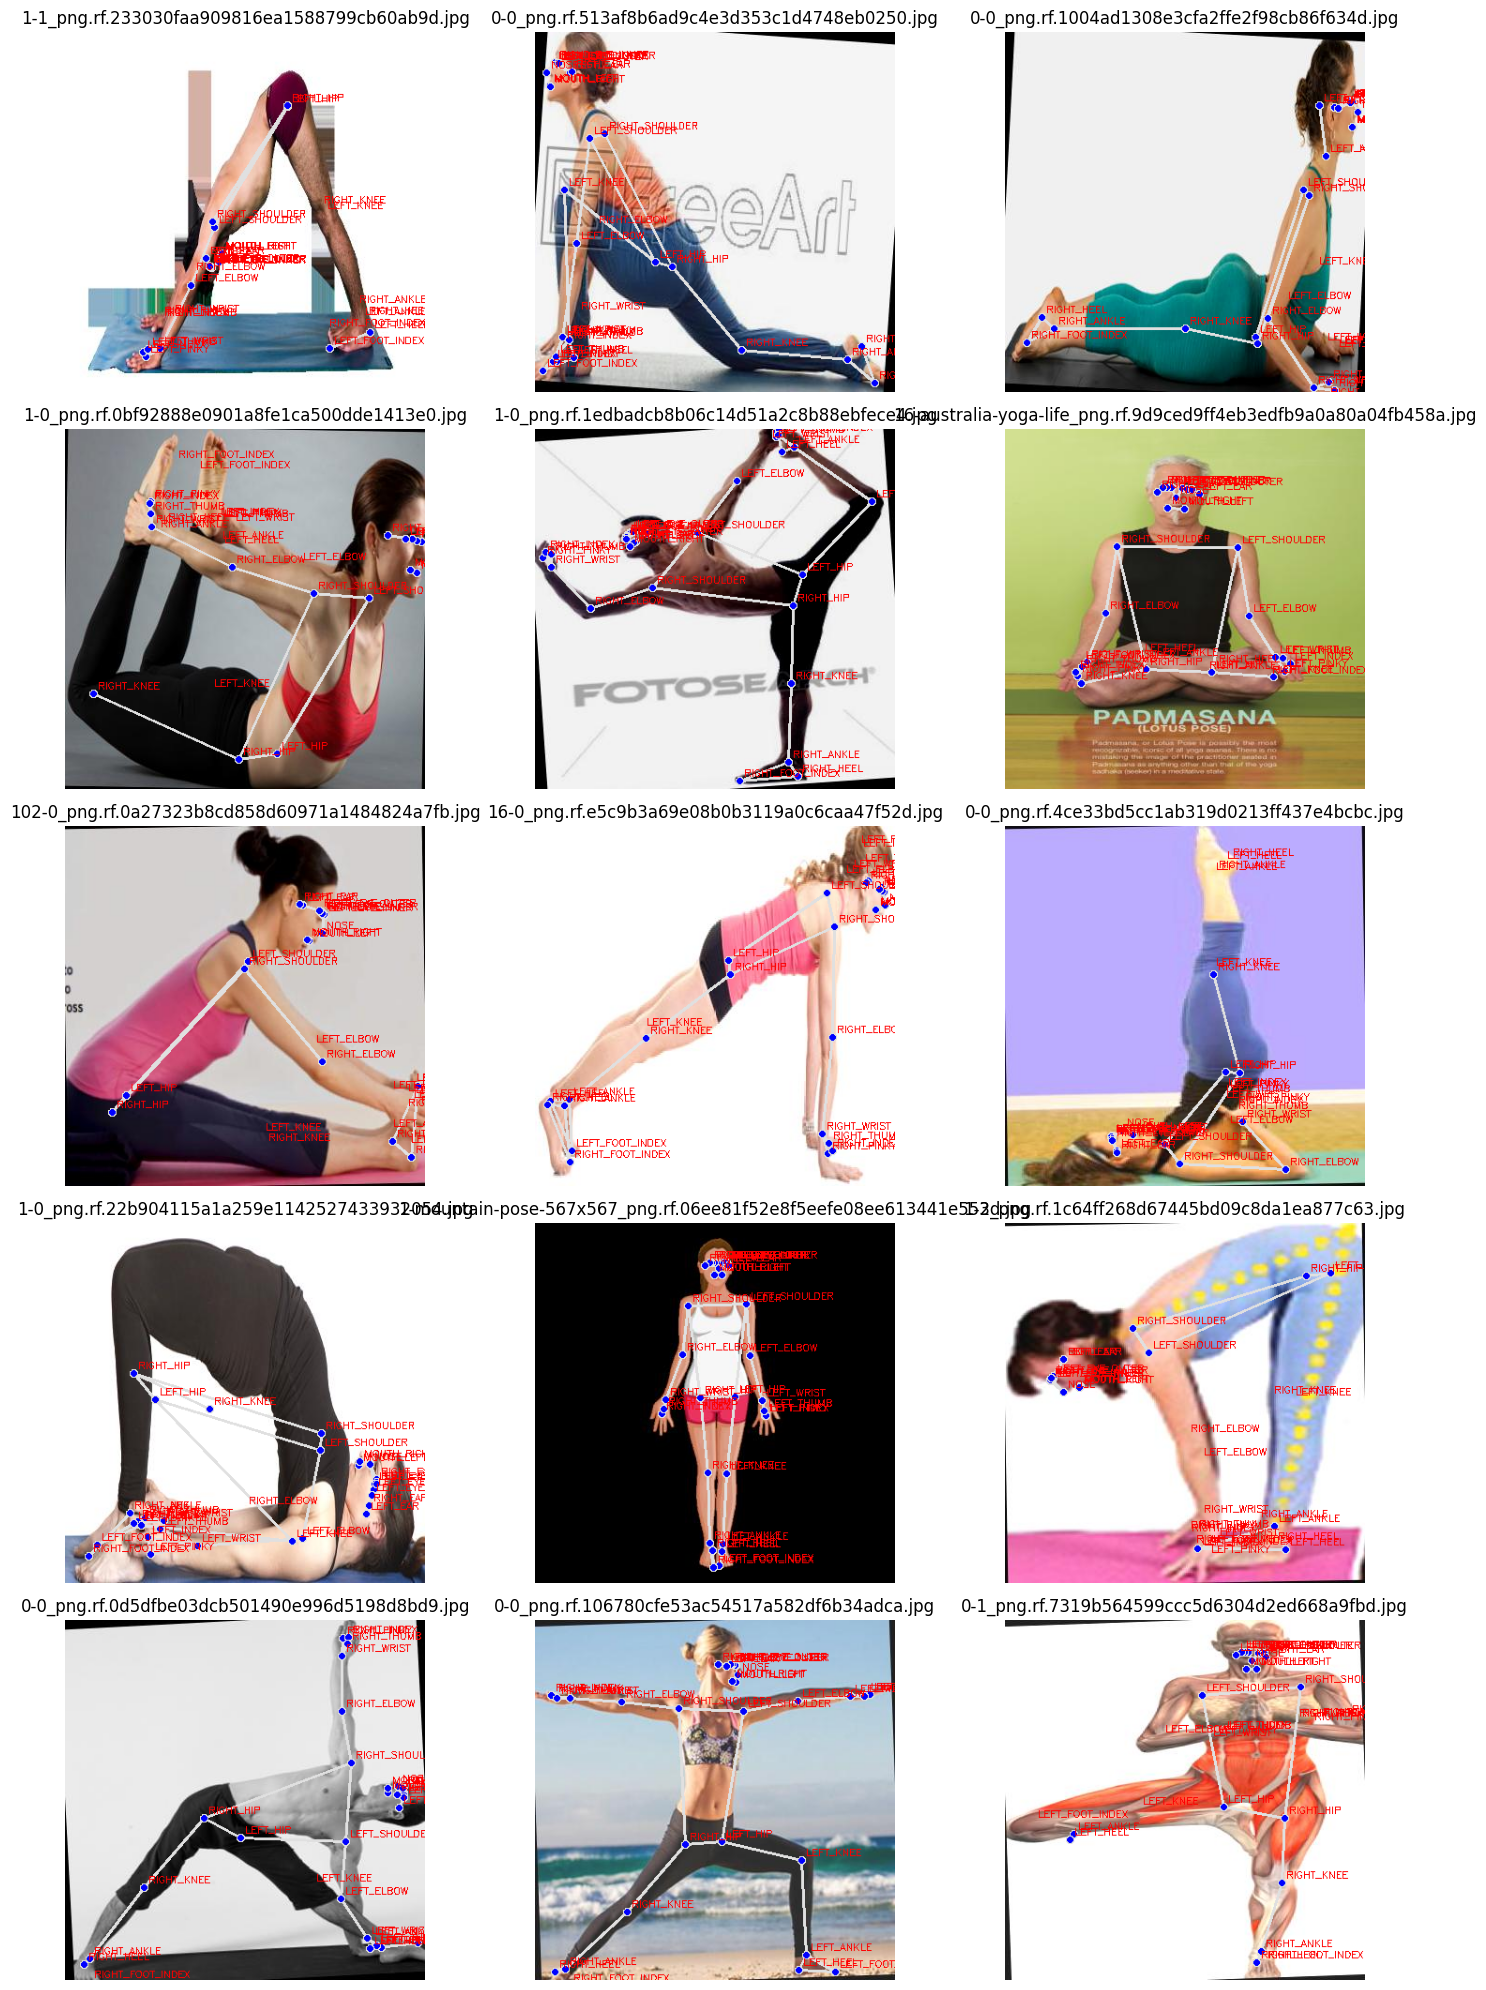

In [22]:
import cv2
import matplotlib.pyplot as plt

def draw_landmarks_with_names(image_rgb, results):
    """Draw skeleton + keypoint labels on the image."""
    if not results.pose_landmarks:
        return image_rgb

    lm = results.pose_landmarks.landmark

    # Draw skeleton
    mp_drawing.draw_landmarks(
        image_rgb,
        results.pose_landmarks,
        mp_pose.POSE_CONNECTIONS
    )

    # Draw keypoint names
    h, w = image_rgb.shape[:2]
    for i, landmark in enumerate(lm):
        cx, cy = int(landmark.x * w), int(landmark.y * h)
        name = mp_pose.PoseLandmark(i).name
        cv2.putText(image_rgb, name, (cx+5, cy-5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.35, (255,0,0), 1)
    return image_rgb

test_images = [
    "/content/dataset/train/adho mukha svanasana/1-1_png.rf.233030faa909816ea1588799cb60ab9d.jpg",
    "/content/dataset/train/anjaneyasana/0-0_png.rf.513af8b6ad9c4e3d353c1d4748eb0250.jpg",
    "/content/dataset/train/bhujangasana/0-0_png.rf.1004ad1308e3cfa2ffe2f98cb86f634d.jpg",

    "/content/dataset/train/dhanurasana/1-0_png.rf.0bf92888e0901a8fe1ca500dde1413e0.jpg",
    "/content/dataset/train/natarajasana/1-0_png.rf.1edbadcb8b06c14d51a2c8b88ebfece4.jpg",
    "/content/dataset/train/padmasana/16-australia-yoga-life_png.rf.9d9ced9ff4eb3edfb9a0a80a04fb458a.jpg",

    "/content/dataset/train/paschimottanasana/102-0_png.rf.0a27323b8cd858d60971a1484824a7fb.jpg",
    "/content/dataset/train/phalakasana/16-0_png.rf.e5c9b3a69e08b0b3119a0c6caa47f52d.jpg",
    "/content/dataset/train/salamba sarvangasana/0-0_png.rf.4ce33bd5cc1ab319d0213ff437e4bcbc.jpg",

    "/content/dataset/train/setu bandha sarvangasana/1-0_png.rf.22b904115a1a259e1142527433932054.jpg",
    "/content/dataset/train/tadasana/1-mountain-pose-567x567_png.rf.06ee81f52e8f5eefe08ee613441e553d.jpg",
    "/content/dataset/train/uttanasana/1-2_png.rf.1c64ff268d67445bd09c8da1ea877c63.jpg",

    "/content/dataset/train/utthita trikonasana/0-0_png.rf.0d5dfbe03dcb501490e996d5198d8bd9.jpg",
    "/content/dataset/train/virabhadrasana ii/0-0_png.rf.106780cfe53ac54517a582df6b34adca.jpg",
    "/content/dataset/train/vriksasana/0-1_png.rf.7319b564599ccc5d6304d2ed668a9fbd.jpg",

]


plt.figure(figsize=(15, 20))
cols = 3
rows = 5

for idx, img_path in enumerate(test_images[:15]):
    image = cv2.imread(img_path)
    if image is None:
        print("Cannot read:", img_path)
        continue

    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    results = pose.process(img_rgb)
    img_rgb = draw_landmarks_with_names(img_rgb, results)

    plt.subplot(rows, cols, idx + 1)
    plt.imshow(img_rgb)
    plt.title(os.path.basename(img_path))
    plt.axis("off")

plt.tight_layout()
plt.show()


In [23]:
import cv2
import os

def print_keypoints(img_path):
    image = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    results = pose.process(img_rgb)

    if not results.pose_landmarks:
        print(f"\n{os.path.basename(img_path)} → NO POSE DETECTED")
        return

    lm = results.pose_landmarks.landmark

    print(f"\n============================")
    print(f"KEYPOINTS FOR: {os.path.basename(img_path)}")
    print(f"============================")

    for i, landmark in enumerate(lm):
        name = mp_pose.PoseLandmark(i).name
        print(f"{name}: x={landmark.x:.4f}, y={landmark.y:.4f}, "
              f"z={landmark.z:.4f}, vis={landmark.visibility:.4f}")

# ---- RUN FOR 15 IMAGES ----
for path in test_images:
    print_keypoints(path)



KEYPOINTS FOR: 1-1_png.rf.233030faa909816ea1588799cb60ab9d.jpg
NOSE: x=0.4281, y=0.6400, z=0.0579, vis=0.9841
LEFT_EYE_INNER: x=0.4047, y=0.6535, z=0.0075, vis=0.9650
LEFT_EYE: x=0.4024, y=0.6520, z=0.0070, vis=0.9688
LEFT_EYE_OUTER: x=0.4001, y=0.6505, z=0.0069, vis=0.9755
RIGHT_EYE_INNER: x=0.4063, y=0.6540, z=0.0804, vis=0.9753
RIGHT_EYE: x=0.4049, y=0.6529, z=0.0796, vis=0.9833
RIGHT_EYE_OUTER: x=0.4029, y=0.6521, z=0.0793, vis=0.9844
LEFT_EAR: x=0.3915, y=0.6284, z=-0.1224, vis=0.9721
RIGHT_EAR: x=0.3920, y=0.6298, z=0.2107, vis=0.9293
MOUTH_LEFT: x=0.4337, y=0.6150, z=0.0280, vis=0.9441
MOUTH_RIGHT: x=0.4357, y=0.6158, z=0.1203, vis=0.9347
LEFT_SHOULDER: x=0.4164, y=0.5433, z=-0.2433, vis=0.9989
RIGHT_SHOULDER: x=0.4099, y=0.5270, z=0.4054, vis=0.9931
LEFT_ELBOW: x=0.3506, y=0.7037, z=-0.4651, vis=0.8445
RIGHT_ELBOW: x=0.3539, y=0.6733, z=0.4756, vis=0.0048
LEFT_WRIST: x=0.2640, y=0.8791, z=-0.4349, vis=0.8337
RIGHT_WRIST: x=0.2942, y=0.7891, z=0.1604, vis=0.0253
LEFT_PINKY: x=0

In [13]:
import os

train_dir = "/content/dataset/train"

classes = sorted([
    c for c in os.listdir(train_dir)
    if os.path.isdir(os.path.join(train_dir, c))
])

print("📦 Dataset Summary:\n")

total_images = 0

for cls in classes:
    cls_path = os.path.join(train_dir, cls)
    imgs = [
        f for f in os.listdir(cls_path)
        if f.lower().endswith(('.jpg','.jpeg','.png'))
    ]

    count = len(imgs)
    total_images += count

    print(f"{cls:30} → {count} images")

print("\nTotal images:", total_images)
print("Total classes:", len(classes))


📦 Dataset Summary:

adho mukha svanasana           → 171 images
anjaneyasana                   → 159 images
bhujangasana                   → 156 images
dhanurasana                    → 108 images
natarajasana                   → 180 images
padmasana                      → 153 images
paschimottanasana              → 123 images
phalakasana                    → 126 images
salamba sarvangasana           → 141 images
setu bandha sarvangasana       → 144 images
tadasana                       → 120 images
uttanasana                     → 150 images
utthita trikonasana            → 189 images
virabhadrasana ii              → 138 images
vriksasana                     → 150 images

Total images: 2208
Total classes: 15


In [14]:
pose_names = [name for name in sorted(os.listdir(train_dir)) if not name.startswith('.')]
pose_to_id = {name: i for i, name in enumerate(pose_names)}
print(pose_to_id)

{'adho mukha svanasana': 0, 'anjaneyasana': 1, 'bhujangasana': 2, 'dhanurasana': 3, 'natarajasana': 4, 'padmasana': 5, 'paschimottanasana': 6, 'phalakasana': 7, 'salamba sarvangasana': 8, 'setu bandha sarvangasana': 9, 'tadasana': 10, 'uttanasana': 11, 'utthita trikonasana': 12, 'virabhadrasana ii': 13, 'vriksasana': 14}


In [25]:
X = []
y = []

x = 1
for pose_name in pose_names:
    pose_folder = os.path.join(train_dir, pose_name)
    print(pose_folder)
    for img_file in os.listdir(pose_folder):
        if not img_file.lower().endswith((".jpg", ".png", ".jpeg")):
            continue

        img_path = os.path.join(pose_folder, img_file)
        print(img_path)

        features = process_image(img_path)
        if features is None:
            continue

        X.append(features)
        y.append(pose_to_id[pose_name])
        print(x)
        x += 1


/content/dataset/train/adho mukha svanasana
/content/dataset/train/adho mukha svanasana/39-screen-shot-2019-01-02-at-5-02-56-pm_png.rf.93d785d82c62c19d2da7aa2e011f9eb4.jpg
1
/content/dataset/train/adho mukha svanasana/13-downward-facing-dog-800x490_png.rf.e2ca725274de334f1498f531456f63d2.jpg
2
/content/dataset/train/adho mukha svanasana/34-adho-mukha-svanasana_png.rf.8e539ad725c8b197ad507d3198a092da.jpg
3
/content/dataset/train/adho mukha svanasana/32-down_dog_orthocarolina_winston_png.rf.e27fbc3d6de6611887e573114438dd88.jpg
4
/content/dataset/train/adho mukha svanasana/56-dd2_png.rf.97154d8943f2ef8f651baecb1a5878bb.jpg
5
/content/dataset/train/adho mukha svanasana/60-adho-mukha-svanasana-downward-dog_png.rf.ee0309b22fbb5303605f05477cf2510b.jpg
6
/content/dataset/train/adho mukha svanasana/39-untitled10_png.rf.4ce18ab076ff990617643573a4efe27e.jpg
7
/content/dataset/train/adho mukha svanasana/35-068155f5a8d0310c34a6ed06cb089294_png.rf.fd40abce88ce0bdeb48243647d9db3a1.jpg
/content/datase

In [27]:
X = np.array(X)
y = np.array(y)

In [28]:
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (1806, 25)
y shape: (1806,)


# Classifier: SVM

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [30]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

In [31]:
from sklearn.svm import SVC

svm_model = SVC(
    kernel='rbf',
    C=10,
    gamma='scale',
    probability=True
)

svm_model.fit(X_train_scaled, y_train)

SVC(C=10, probability=True)

In [32]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = svm_model.predict(X_valid_scaled)

print("Accuracy:", accuracy_score(y_valid, y_pred))
print(classification_report(y_valid, y_pred, target_names=pose_names))

Accuracy: 0.93646408839779
                          precision    recall  f1-score   support

    adho mukha svanasana       1.00      0.90      0.95        31
            anjaneyasana       0.97      1.00      0.98        31
            bhujangasana       0.95      0.78      0.86        23
             dhanurasana       0.94      0.84      0.89        19
            natarajasana       0.97      0.97      0.97        31
               padmasana       0.97      1.00      0.98        28
       paschimottanasana       1.00      0.83      0.91        12
             phalakasana       0.87      0.95      0.91        21
    salamba sarvangasana       0.82      0.88      0.85        16
setu bandha sarvangasana       0.96      0.88      0.92        26
                tadasana       0.89      0.89      0.89        19
              uttanasana       0.76      0.95      0.84        20
     utthita trikonasana       1.00      1.00      1.00        37
       virabhadrasana ii       1.00      1.00   

In [33]:
import pickle

with open("svm_classifier.pkl", "wb") as f:
    pickle.dump({
        "model": svm_model,
        "scaler": scaler,
        "pose_names": pose_names
    }, f)

# Test Model

In [34]:
import pickle

with open("svm_classifier.pkl", "rb") as f:
    data = pickle.load(f)

svm_model = data["model"]
scaler = data["scaler"]
pose_names = data["pose_names"]

In [35]:
def classify_pose(img_path):
    features = process_image(img_path)

    if features is None:
        return "Pose not detected"

    features = features.reshape(1, -1)
    features_scaled = scaler.transform(features)

    pred_id = svm_model.predict(features_scaled)[0]
    pred_name = pose_names[pred_id]

    return pred_name

In [37]:
img_path = "/content/test-img1.jpeg"
classify_pose(img_path)

'dhanurasana'

In [38]:
img_path = "/content/test-img2.jpeg"
classify_pose(img_path)

'anjaneyasana'